In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

## Get windows, zscores, and annotations, including vista-enhancer counts

I used 

```
download-process-data/vista-enhancers/download.sh
```

to download vista enhancers, and then used https://genome.ucsc.edu/cgi-bin/hgLiftOver to translate the coordinates of the enhancers from `hg19` to `hg38`. 

I used the following script to compute the number of positive vista enhancers that overlap each window:

```
experiments/germline-model/chen-et-al-2022/add-vista-enhancer-counts.sh
```

writing the vista-enhancer counts to: 

```
/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.positive-vista-enhancers.bed
``` 

In [3]:
import pandas as pd 

pd.set_option('display.max_columns', 50)

TRAIN_SET_LABEL = 'noncoding'

def get_windows_scores_annotations():
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.positive-vista-enhancers.bed'
    df = pd.read_csv(filename, sep='\t')
    df['delta_sf'] = df['N_observed'] - df[f'N_mean_null_7_{TRAIN_SET_LABEL}']
    df['delta_f'] = df[f'N_mean_null_7_{TRAIN_SET_LABEL}'] - df[f'N_mean_null_3_{TRAIN_SET_LABEL}']
    df['window overlaps positive vista enhancer'] = df['positive-vista-enhancer count'] > 0    
    return df

windows_scores_annotations = get_windows_scores_annotations()
windows_scores_annotations

,chromosome,start,end,N_observed,N_bar_7_noncoding,N_mean_null_7_noncoding,N_variance_null_7_noncoding,N_bar_1_noncoding,N_mean_null_1_noncoding,N_variance_null_1_noncoding,N_bar_1_noncoding_noisy,N_mean_null_1_noncoding_noisy,N_variance_null_1_noncoding_noisy,N_bar_3_noncoding,N_mean_null_3_noncoding,N_variance_null_3_noncoding,N_bar_3_noncoding_noisy,N_mean_null_3_noncoding_noisy,N_variance_null_3_noncoding_noisy,N_bar_5_noncoding,N_mean_null_5_noncoding,N_variance_null_5_noncoding,N_bar_5_noncoding_noisy,N_mean_null_5_noncoding_noisy,N_variance_null_5_noncoding_noisy,enhancer overlap,merged_exon overlap,window overlaps enhancer,window overlaps merged_exon,"window overlaps (enhancer, merged_exon)",new chen zscore,positive-vista-enhancer count,delta_sf,delta_f,window overlaps positive vista enhancer
0,chr1,1432000,1433000,260,-0.372778,265.321432,203.777753,1.590921,236.519249,217.834403,1.676924,235.282294,217.264932,-0.247615,263.528599,203.072610,-0.283079,264.038617,203.540686,-0.339806,264.852332,203.910737,-0.340167,264.858613,204.004160,1000.0,NaN,True,False,"(True, False)",4.299894,0,-5.321432,1.792832,False
1,chr1,1435000,1436000,275,-6.280673,368.627875,222.227572,2.097960,243.596443,224.059444,2.193623,242.210058,223.438246,-7.547130,387.939429,223.937877,-7.609011,389.032484,224.595337,-6.810107,375.796139,219.068492,-6.784165,375.458319,219.269877,1000.0,444.0,True,True,"(True, True)",3.331645,0,-93.627875,-19.311554,False
2,chr1,1449000,1450000,225,0.139977,223.137143,177.111728,0.959620,211.569144,195.888493,1.011359,210.858989,195.501382,0.258359,221.559138,177.372370,0.225283,221.996472,177.748203,0.330975,220.612316,175.743926,0.330023,220.624461,175.781765,NaN,311.0,False,True,"(False, True)",1.817267,0,1.862857,1.578005,False
3,chr1,1450000,1451000,313,2.524948,277.859484,193.691881,5.870332,227.882674,210.237742,5.950235,226.828073,209.731395,2.197534,281.968822,199.400099,2.147648,282.634862,199.905291,2.480911,278.322530,195.376527,2.482902,278.288535,195.445943,NaN,758.0,False,True,"(False, True)",1.365863,0,35.140516,-4.109338,False
4,chr1,1451000,1452000,293,2.951595,252.829443,185.226049,4.803930,223.924244,206.755939,4.877094,222.953222,206.278524,2.367303,260.131776,192.772432,2.332657,260.580640,193.155585,2.725116,255.650992,187.839972,2.724052,255.656435,187.931976,NaN,NaN,False,False,"(False, False)",0.666316,0,40.170557,-7.302333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786072,chr9,137269000,137270000,210,-3.060479,251.650751,185.210985,-0.657779,219.366052,202.746590,-0.596997,218.491272,202.302491,-3.445370,257.657992,191.337298,-3.474260,258.105694,191.720447,-3.228932,254.283943,188.093965,-3.225423,254.247196,188.190706,1000.0,NaN,True,False,"(True, False)",5.276351,0,-41.650751,-6.007241,False
1786073,chr9,137275000,137276000,296,1.990841,268.077912,196.708291,4.575436,229.442056,211.609361,4.655896,228.354529,211.091617,1.921453,268.932391,198.445131,1.881115,269.472162,198.871703,1.974808,268.272874,197.133316,1.977276,268.231681,197.226096,712.0,NaN,True,False,"(True, False)",2.687348,0,27.922088,-0.854479,False
1786074,chr9,137282000,137283000,211,-1.612483,232.654005,180.337479,-0.329061,215.647526,199.475805,-0.272968,214.851260,199.058885,-1.919711,237.194349,186.184553,-1.941497,237.514975,186.512986,-1.783906,235.171685,183.598811,-1.783008,235.161871,183.634632,572.0,641.0,True,True,"(True, True)",-0.090791,0,-21.654005,-4.540344,False
1786075,chr9,137290000,137291000,224,-0.215971,226.884483,178.380280,0.419311,218.046575,201.585989,0.479479,217.199655,201.151534,-0.682673,233.338243,187.113535,-0.708182,233.697227,187.501923,-0.522518,231.079535,183.571865,-0.521048,231.060300,183.607554,NaN,NaN,False,False,"(False, False)",2.162811,0,-2.884483,-6.453759,False


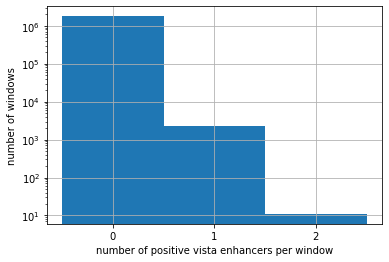

In [4]:
import numpy as np 

axis = windows_scores_annotations['positive-vista-enhancer count'].hist(bins=np.arange(-0.5, 3.5, 1))
axis.set_yscale('log')
axis.set_xlabel('number of positive vista enhancers per window')
axis.set_ylabel('number of windows')
_ = axis.set_xticks(np.arange(0, 3, step=1))

## Balance the number of windows that do and do not overlap positive vista enhancers

In [5]:
def balance_classes(df, sample_size):
    df = (
        df
        .groupby('window overlaps positive vista enhancer', as_index=True)
        .apply(lambda group_df: group_df.sample(n=sample_size))
        .reset_index(drop=True)
    )
    return df 

windows_scores_annotations = balance_classes(windows_scores_annotations, sample_size=2000)

print(len(windows_scores_annotations))

4000


In [6]:
windows_scores_annotations_coding = windows_scores_annotations[windows_scores_annotations['window overlaps merged_exon'] == True]
windows_scores_annotations_noncoding = windows_scores_annotations[windows_scores_annotations['window overlaps merged_exon'] == False]

print(len(windows_scores_annotations_coding), len(windows_scores_annotations_noncoding))

616 3384


## 7mer zscore (delta_sf) appears to enrich for positive vista enhancers, but we don't know whether delta_f enriches for them too

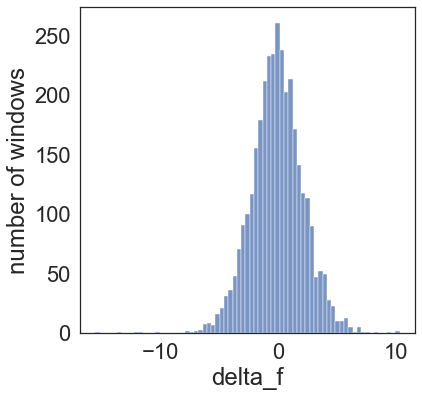

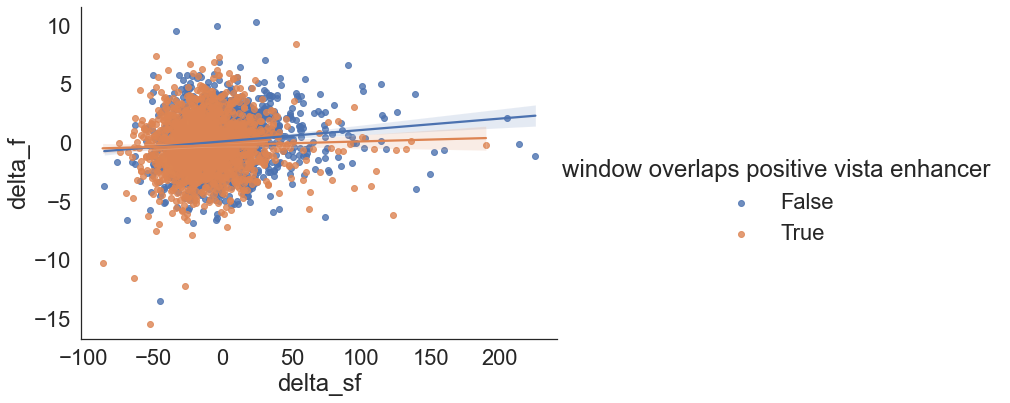

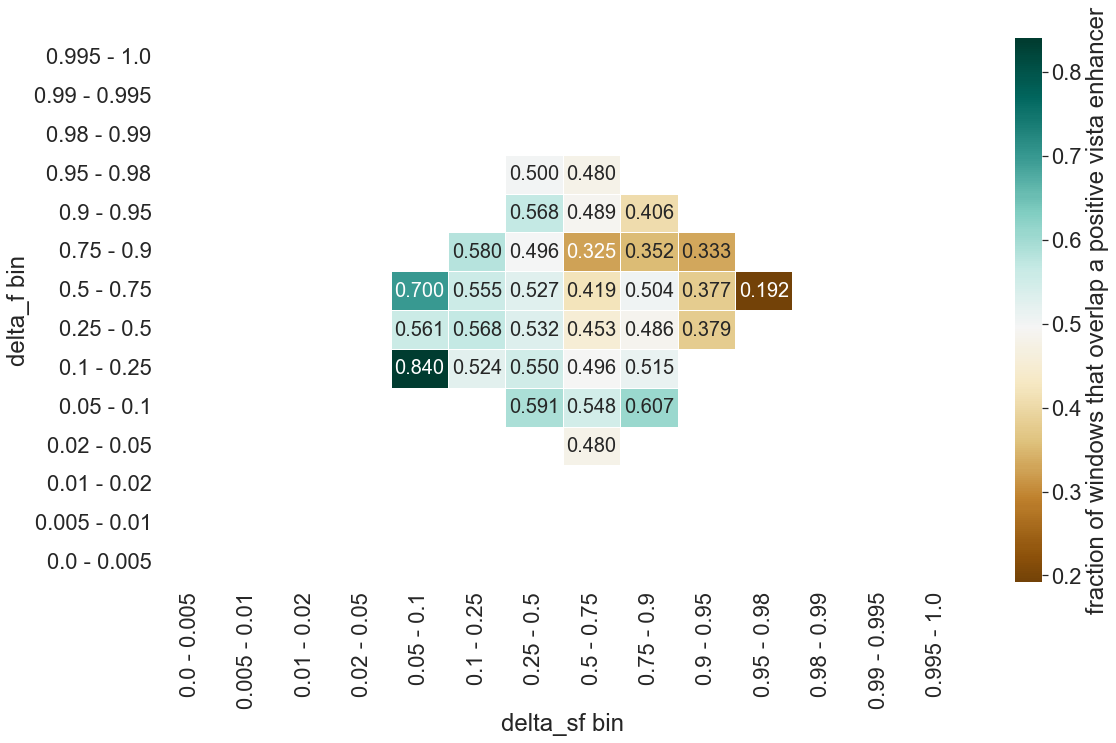

In [8]:
import seaborn as sns 
sns.set(font_scale = 2)

import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (18, 10)
})

import numpy as np 

def baseline_fraction_of_windows_that_overlap_enhancer(df, z): 
    return np.mean(df[z['column']])

def aggregate_2d(grouped_windows, x, y, z, aggregation_function): 
    aggregated = grouped_windows.agg({z["column"]: [aggregation_function]})
    aggregated.columns = [f'{z["column"]} ({aggregation_function})']
    aggregated = aggregated.reset_index()
    
    # pivot the data into a 2d array 
    # https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-by-pivoting-dataframe-objects
    aggregated = aggregated.pivot(index=f'{y["column"]} bin', columns=f'{x["column"]} bin', values=f'{z["column"]} ({aggregation_function})')
    
    return aggregated
  
import warnings

def compute_quantile_labels(array_of_quantiles):
    starts = array_of_quantiles[:-1]
    ends = array_of_quantiles[1:]
    quantile_labels = [f'{start} - {end}' for start, end in zip(starts, ends)]    
    return quantile_labels

def label_windows_with_score_quantiles_core(df, array_of_quantiles, score): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")        

        quantile_labels = compute_quantile_labels(array_of_quantiles)

        df[f'{score} bin'], bins = pd.qcut(
            df[score],
            q = array_of_quantiles, 
            labels = quantile_labels, 
            retbins = True,
    #         duplicates='drop'
        )

        return df

def plot_heat_map(df, x, y, z, count_threshold): 
    df = label_windows_with_score_quantiles_core(df, x['array_of_quantiles'], score=x['column'])
    df = label_windows_with_score_quantiles_core(df, y['array_of_quantiles'], score=y['column'])
    grouped_windows = df.groupby([f'{x["column"]} bin', f'{y["column"]} bin'])
    sample_mean = aggregate_2d(grouped_windows, x, y, z, 'mean')

    sample_size = pd.DataFrame(grouped_windows.size())
    sample_size.columns = ['counts']
    sample_size = sample_size.reset_index()
    # pivot the data into a 2d array
    # https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-by-pivoting-dataframe-objects
    sample_size = sample_size.pivot(index=f'{y["column"]} bin', columns=f'{x["column"]} bin', values='counts')
    
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    ax = sns.heatmap(
        sample_mean, 
        cmap = 'BrBG', 
        center = baseline_fraction_of_windows_that_overlap_enhancer(df, z), 
        annot = True, 
        fmt = '.3f',
        linewidths = .5, 
        cbar_kws = {'label': z['label']},
        mask = sample_size < count_threshold
    )
    ax.invert_yaxis()

def plot_delta_f(df): 
    fig, ax = plt.subplots(figsize=(6,6))
    sns.histplot(data=df, x="delta_f", ax=ax)
    plt.ylabel('number of windows')
    plt.show() 
    
def plot_classes(df): 
    sns.lmplot(data=df, x='delta_sf', y='delta_f', hue='window overlaps positive vista enhancer', height=6, aspect=1.5)
    plt.show() 
    
def plot_heat_map_wrapper(df):
    with sns.axes_style("white"):
        plot_delta_f(df)  
        plot_classes(df)
        return plot_heat_map(
            df,
            x = {
                'column': 'delta_sf',
                'array_of_quantiles': [0.00, 0.005, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.98, 0.99, 0.995, 1.00],
            },
            y = { 
                'column': 'delta_f',
                'array_of_quantiles': [0.00, 0.005, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.98, 0.99, 0.995, 1.00],
            },
            z = {
                'column': 'window overlaps positive vista enhancer',
                'label': 'fraction of windows that overlap a positive vista enhancer',
            },
            count_threshold = 25,
        )
            
plot_heat_map_wrapper(windows_scores_annotations_noncoding)